In [1]:
import sys
# If you want to re-run, just modify this to where you put the NS_NFMC fork of the PyMC3 repo.
sys.path.insert(1, '/home/richard/pymc3_dev/')
import arviz as az
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
from pymc3.theanof import inputvars
import theano
import theano.tensor as tt
import seaborn as sns
import pandas as pd

print(f"Running on PyMC3 v{pm.__version__}")

az.style.use("arviz-darkgrid")

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Running on PyMC3 v3.11.0


In [2]:
n = 4

mu1 = np.ones(n) * (1.0 / 2)
mu2 = -mu1

stdev = 0.1
sigma = np.power(stdev, 2) * np.eye(n)
isigma = np.linalg.inv(sigma)
dsigma = np.linalg.det(sigma)

w1 = 0.3  # one mode with 0.3 of the mass 
w2 = 1 - w1  # the other mode with 0.7 of the mass

def two_gaussians(x):
    log_like1 = (
        -0.5 * n * tt.log(2 * np.pi)
        - 0.5 * tt.log(dsigma)
        - 0.5 * (x - mu1).T.dot(isigma).dot(x - mu1)
    )
    log_like2 = (
        -0.5 * n * tt.log(2 * np.pi)
        - 0.5 * tt.log(dsigma)
        - 0.5 * (x - mu2).T.dot(isigma).dot(x - mu2)
    )
    return pm.math.logsumexp([tt.log(w1) + log_like1, tt.log(w2) + log_like2])

with pm.Model() as model:
    X = pm.Uniform(
        "X",
        shape=n,
        lower=-2.0 * np.ones_like(mu1),
        upper=2.0 * np.ones_like(mu1),
        testval=-1.0 * np.ones_like(mu1),
    )
    #X = pm.Normal('X', mu=0, sigma=1, shape=n)
    
    llk = pm.Potential("llk", two_gaussians(X))
    
    smc_trace = pm.sample_smc(1000)
    init_samples = smc_trace.get_values('X')
    print(np.shape(init_samples))
    
with model:
    
    trace = pm.sample_nfmc(2000, init_samples=init_samples, optim_iter=1000, nf_iter=10, chains=1,
                           frac_validate=0.2, alpha=(0.75,0.75), parallel=False,
                           ftol=1.0e-12, NBfirstlayer=True, bw_factor=0.5, k_trunc=0.25, pareto=False)
    az_trace = az.from_pymc3(trace)

Initializing SMC sampler...
Sampling 2 chains in 0 job
/home/richard/pymc3_dev/pymc3/sampling.py:1924: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(
Stage:   0 Beta: 0.010
Stage:   1 Beta: 0.029
Stage:   2 Beta: 0.066
Stage:   3 Beta: 0.144
Stage:   4 Beta: 0.318
Stage:   5 Beta: 0.687
Stage:   6 Beta: 1.000
/home/richard/pymc3_dev/pymc3/sampling.py:1924: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(
Stage:   0 Beta: 0.010
Stage:   1 Beta: 0.029
Stage:   2 Beta: 0.066
Stage:   3 Beta: 0.147
Stage:   4 Beta: 0.317
Stage:   5 Beta: 0.673
Stage:   6 Beta: 1.000
Initializing normalizing flow based sampling...
Sampling 1 chain Cores available for optimization: 0


(2000, 4)
Prior sample check ...
Shape of prior samples = (2000, 4)
Fitting the first NF approx to the initial samples ...


Stage:   1, Normalizing Constant Estimate: 0.003990033528382149


[0.00025335 0.00037054 0.00041453 ... 0.00068706 0.00059405 0.00056614]


Stage:   2, Normalizing Constant Estimate: 0.003875881600914985


[0.00025335 0.00037054 0.00041453 ... 0.00049921 0.00017712 0.00037573]
[0.00025335 0.00037054 0.00041453 ... 0.00181107 0.0004792  0.0018897 ]
Normalizing constant estimate has stabilised - ending NF fits.


In [3]:
nf_evidence = trace.report.evidence
print(f'NFMC calculated evidence = {nf_evidence[0]}')
weighted_samples = trace.report.weighted_samples[0]
q0_samples = weighted_samples[:2000, ...]
importance_weights = trace.report.importance_weights
q0_weights = importance_weights[0][:2000]
az_summary = az.summary(az_trace)
print(az_summary)

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


NFMC calculated evidence = 0.0038885147530954988
       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
X[0] -0.219  0.463  -0.677    0.612      0.011    0.008    1885.0  1885.0   
X[1] -0.215  0.461  -0.699    0.597      0.011    0.007    1917.0  1917.0   
X[2] -0.217  0.467  -0.692    0.607      0.011    0.008    1753.0  1753.0   
X[3] -0.204  0.465  -0.677    0.609      0.011    0.008    1727.0  1727.0   

      ess_bulk  ess_tail  r_hat  
X[0]    2045.0    1992.0    NaN  
X[1]    1937.0    1648.0    NaN  
X[2]    1789.0    1885.0    NaN  
X[3]    1738.0    1945.0    NaN  


<Figure size 720x480 with 0 Axes>

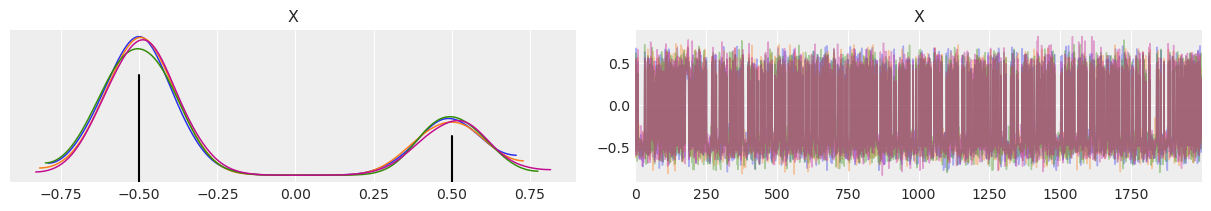

In [4]:
plt.figure()
ax = az.plot_trace(az_trace, compact=True)
for i in range(len(ax)):
    ax[i, 0].axvline(-0.5, 0, 0.7, color='k')
    ax[i, 0].axvline(0.5, 0, 0.3, color='k')
plt.show()

<Figure size 720x480 with 0 Axes>

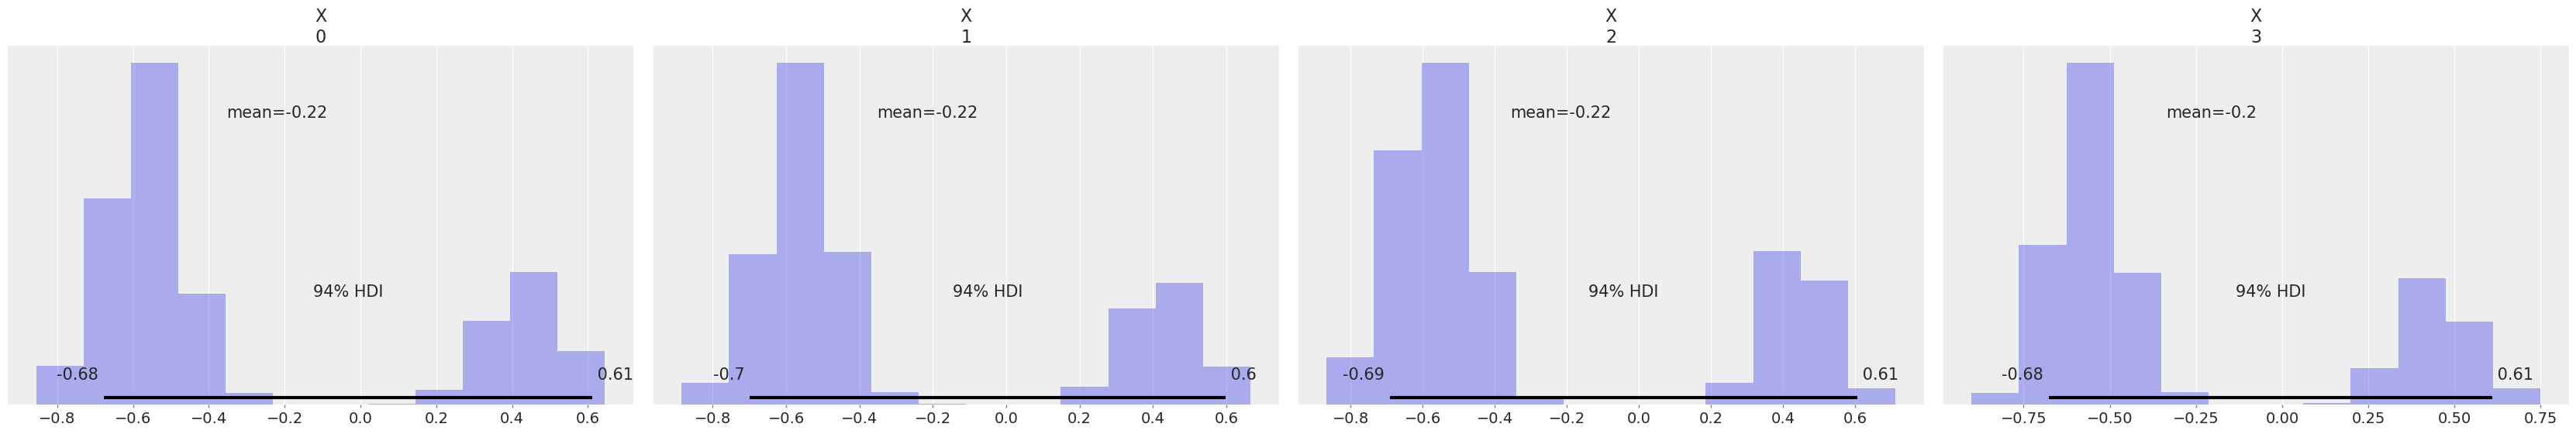

In [5]:
plt.figure()
az.plot_posterior(az_trace, kind='hist')
plt.show()

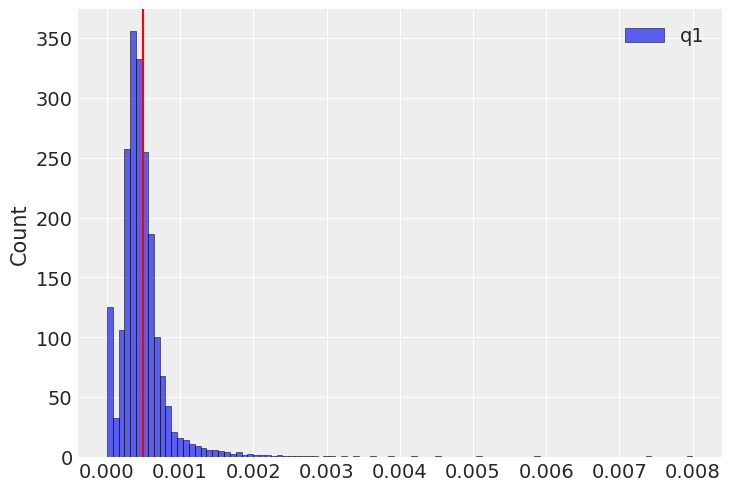

6000


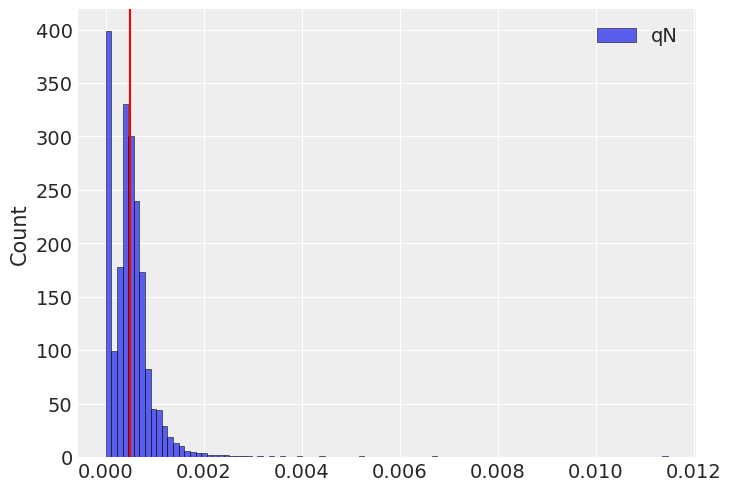

In [6]:
plt.figure()
sns.histplot(importance_weights[0][:2000], bins=100, label='q1')
plt.axvline(x=1/2000, color='r')
plt.legend(loc='upper right')
plt.show()

print(len(importance_weights[0]))

plt.figure()
sns.histplot(importance_weights[0][int(len(importance_weights[0]) - 2000):], bins=100, label='qN')
plt.axvline(x=1/2000, color='r')
plt.legend(loc='upper right')
plt.show()


Let's just check these results against those from SMC. 

In [7]:
with model:
    az_smc_trace = az.from_pymc3(smc_trace)

In [8]:
smc_evidence = np.exp(smc_trace.report.log_marginal_likelihood)
print(f'SMC calculated evidence: {smc_evidence}')
az_smc_summary = az.summary(az_smc_trace)
print(az_smc_summary)

SMC calculated evidence: [0.00339823 0.00336176]
       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
X[0] -0.202  0.468  -0.679    0.609      0.010    0.007    2126.0  1963.0   
X[1] -0.204  0.465  -0.667    0.617      0.010    0.008    2181.0  1880.0   
X[2] -0.202  0.468  -0.674    0.620      0.010    0.007    2048.0  1990.0   
X[3] -0.203  0.471  -0.691    0.623      0.011    0.008    1921.0  1921.0   

      ess_bulk  ess_tail  r_hat  
X[0]    2102.0    1908.0    1.0  
X[1]    2189.0    2004.0    1.0  
X[2]    2009.0    1796.0    1.0  
X[3]    2010.0    1698.0    1.0  


<Figure size 720x480 with 0 Axes>

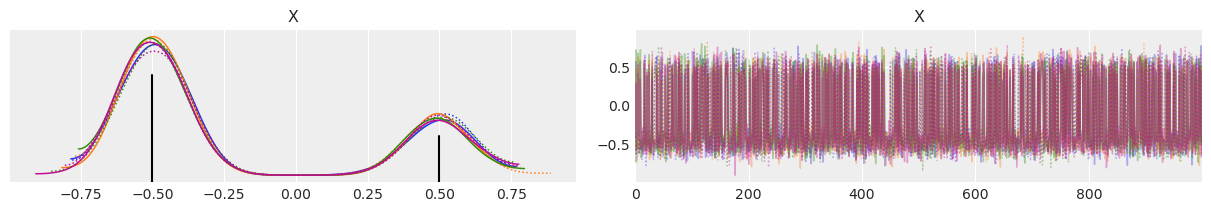

In [9]:
plt.figure()
ax = az.plot_trace(az_smc_trace, compact=True)
for i in range(len(ax)):
    ax[i, 0].axvline(-0.5, 0, 0.7, color='k')
    ax[i, 0].axvline(0.5, 0, 0.3, color='k')
plt.show()

<Figure size 720x480 with 0 Axes>

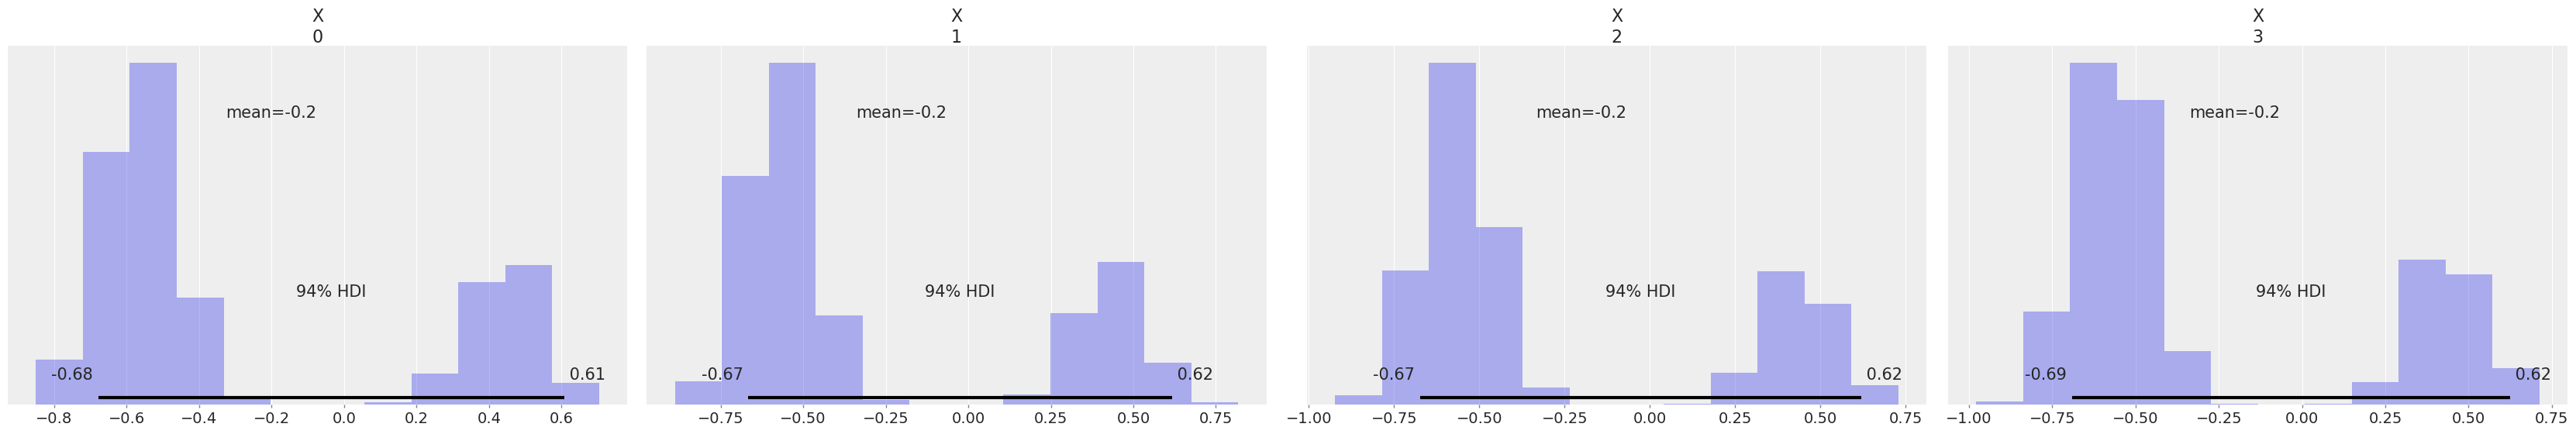

In [10]:
plt.figure()
az.plot_posterior(az_smc_trace, kind='hist')
plt.show()

Below I plot the X[0] posterior obtained from the NFMC and SMC runs. 

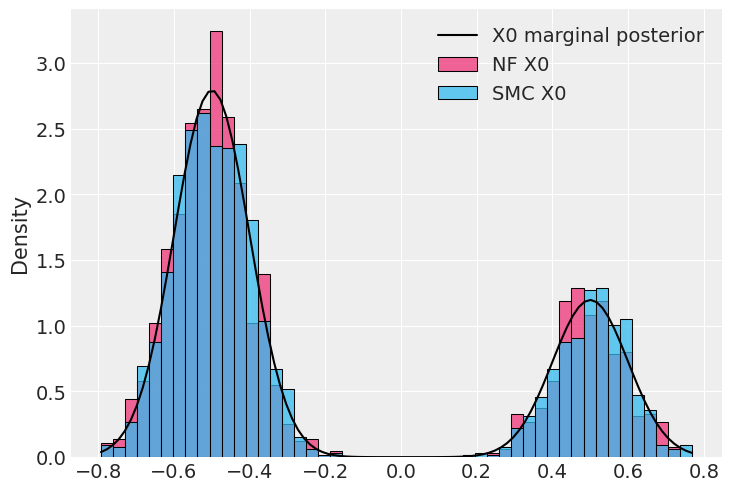

"\nplt.figure()\nsns.distplot(nf_x1, label='NF X1')\nsns.distplot(smc_x1, label='SMC X1')\nplt.legend(loc='upper right')\nplt.show()\n\nplt.figure()\nsns.distplot(nf_x2, label='NF X2')\nsns.distplot(smc_x2, label='SMC X2')\nplt.legend(loc='upper right')\nplt.show()\n\nplt.figure()\nsns.distplot(nf_x3, label='NF X3')\nsns.distplot(smc_x3, label='SMC X3')\nplt.legend(loc='upper right')\nplt.show()\n"

In [11]:
def marginal_two_gauss(x, mu1=0.5, mu2=-0.5, sigma=0.1):
    like1 = np.exp(-(x - mu1)**2 / (2 * sigma**2)) / np.sqrt(2 * np.pi * sigma**2)
    like2 = np.exp(-(x - mu2)**2 / (2 * sigma**2)) / np.sqrt(2 * np.pi * sigma**2)
    return w1 * like1 + w2 * like2

nf_df = az_trace.to_dataframe()
smc_df = az_smc_trace.to_dataframe()

nf_x0 = nf_df[('X[0]', 0)].to_numpy()
nf_x1 = nf_df[('X[1]', 1)].to_numpy()
nf_x2 = nf_df[('X[2]', 2)].to_numpy()
nf_x3 = nf_df[('X[3]', 3)].to_numpy()
smc_x0 = smc_df[('X[0]', 0)].to_numpy()
smc_x1 = smc_df[('X[1]', 1)].to_numpy()
smc_x2 = smc_df[('X[2]', 2)].to_numpy()
smc_x3 = smc_df[('X[3]', 3)].to_numpy()

x_vals = np.linspace(min(np.amin(nf_x0), np.amin(smc_x0)), max(np.amax(nf_x0), np.amax(smc_x0)), 100)
y_vals = marginal_two_gauss(x_vals)

bins = np.linspace(min(np.amin(nf_x0), np.amin(smc_x0)), max(np.amax(nf_x0), np.amax(smc_x0)), 50)
plt.figure()
sns.histplot(nf_x0, label='NF X0', bins=bins, stat='density', color='#EE3377')
sns.histplot(smc_x0, label='SMC X0', bins=bins, stat='density', color='#33BBEE')
plt.plot(x_vals, y_vals, color='k', label='X0 marginal posterior')
plt.legend(loc='upper right')
plt.show()

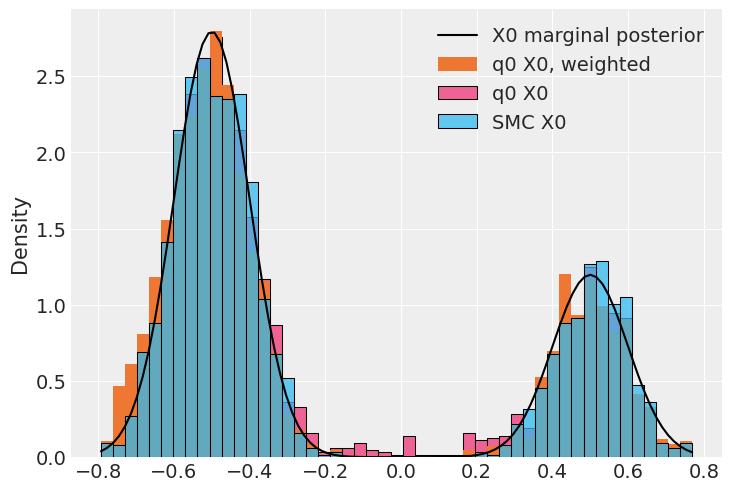

In [18]:
plt.figure()
sns.histplot(q0_samples[:,0], label='q0 X0', bins=bins, stat='density', color='#EE3377')
plt.hist(q0_samples[:,0], weights=q0_weights/np.sum(q0_weights), label='q0 X0, weighted', 
             bins=bins, density=True, color='#EE7733', alpha=0.5)
sns.histplot(smc_x0, label='SMC X0', bins=bins, stat='density', color='#33BBEE')
plt.plot(x_vals, y_vals, color='k', label='X0 marginal posterior')
plt.legend(loc='upper right')
plt.show()

In [40]:
rg_model = pm.Model()
x = np.arange(10)
y = 2 * x + 1 + np.random.normal(scale=0.1)

with rg_model:

    a = pm.Normal('a', mu=2, sigma=1)
    b = pm.Normal('b', mu=1, sigma=1)

    like = pm.Normal('like', mu=a*x+b, sigma=0.1, observed=y)
    
    nuts_trace = pm.sample(1000)
    
    a_samples = nuts_trace.get_values('a')
    b_samples = nuts_trace.get_values('b')

init_samples = np.column_stack((b_samples, a_samples))
print(init_samples)
print(np.shape(init_samples))
    
with rg_model:
    
    rg_trace = pm.sample_nfmc(2000, init_samples=init_samples, optim_iter=1000, nf_iter=10, chains=1,
                              frac_validate=0.2, alpha=(0.75,0.75), parallel=False, bw_factor=0.5,
                              k_trunc=0.25, pareto=False)
    rg_az_trace = az.from_pymc3(rg_trace)

/home/richard/pymc3_dev/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [b, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
The acceptance probability does not match the target. It is 0.695862271687749, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Initializing normalizing flow based sampling...
Sampling 1 chain Cores available for optimization: 0


[[1.00506815 1.99293862]
 [1.0042865  1.99338333]
 [1.03985932 2.00635167]
 ...
 [0.99614567 2.00871588]
 [1.01165015 2.00420139]
 [1.01056    2.00109588]]
(2000, 2)
Prior sample check ...
Shape of prior samples = (2000, 2)
Fitting the first NF approx to the initial samples ...


Stage:   1, Normalizing Constant Estimate: 348.03494012488574


[0.00029791 0.00088148 0.000448   ... 0.0005636  0.00029358 0.00033844]


Stage:   2, Normalizing Constant Estimate: 354.1130585497735


[0.00029791 0.00088148 0.000448   ... 0.00048299 0.00054126 0.00064896]


Stage:   3, Normalizing Constant Estimate: 359.1020781963726


[2.97910118e-004 8.81479037e-004 4.47997291e-004 ... 4.17719586e-004
 8.66354417e-181 4.02622559e-004]


Stage:   4, Normalizing Constant Estimate: 351.7292945176237


[0.00029791 0.00088148 0.000448   ... 0.00047644 0.00051097 0.00050611]
[0.00029791 0.00088148 0.000448   ... 0.00037684 0.00063276 0.00053403]
Normalizing constant estimate has stabilised - ending NF fits.


<Figure size 720x480 with 0 Axes>

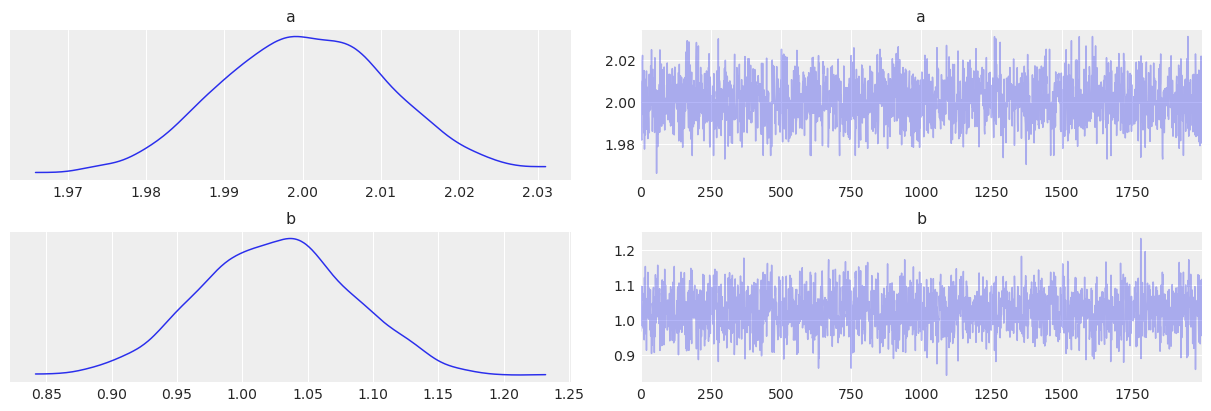

In [41]:
plt.figure()
ax = az.plot_trace(rg_az_trace)
plt.show()

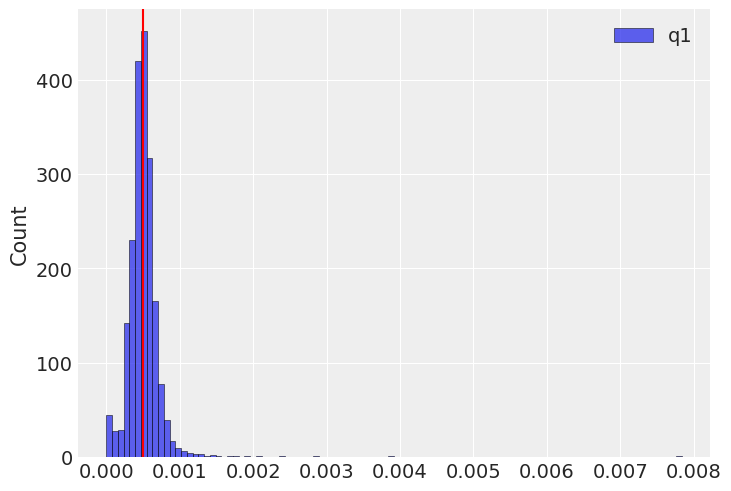

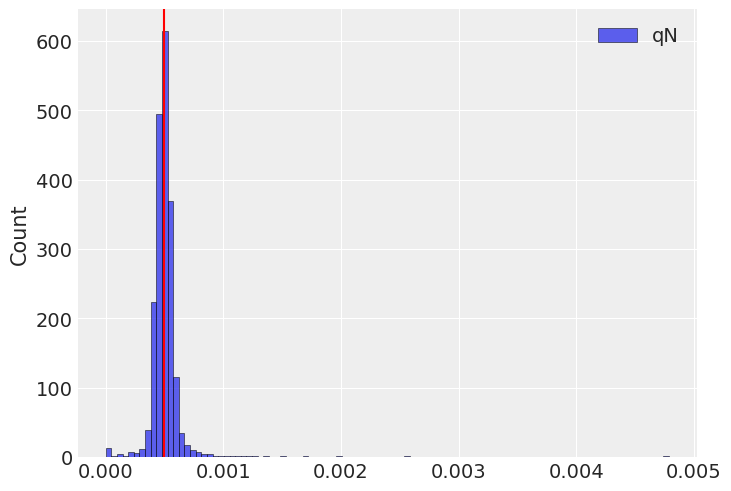

In [42]:
rg_importance_weights = rg_trace.report.importance_weights

plt.figure()
sns.histplot(rg_importance_weights[0][:2000], bins=100, label='q1')
plt.axvline(x=1/2000, color='r')
plt.legend(loc='upper right')
plt.show()


plt.figure()
sns.histplot(rg_importance_weights[0][int(len(rg_importance_weights[0]) - 2000):], bins=100, label='qN')
plt.axvline(x=1/2000, color='r')
plt.legend(loc='upper right')
plt.show()


In [43]:
with rg_model:
    nuts_az_trace = az.from_pymc3(nuts_trace)

<Figure size 720x480 with 0 Axes>

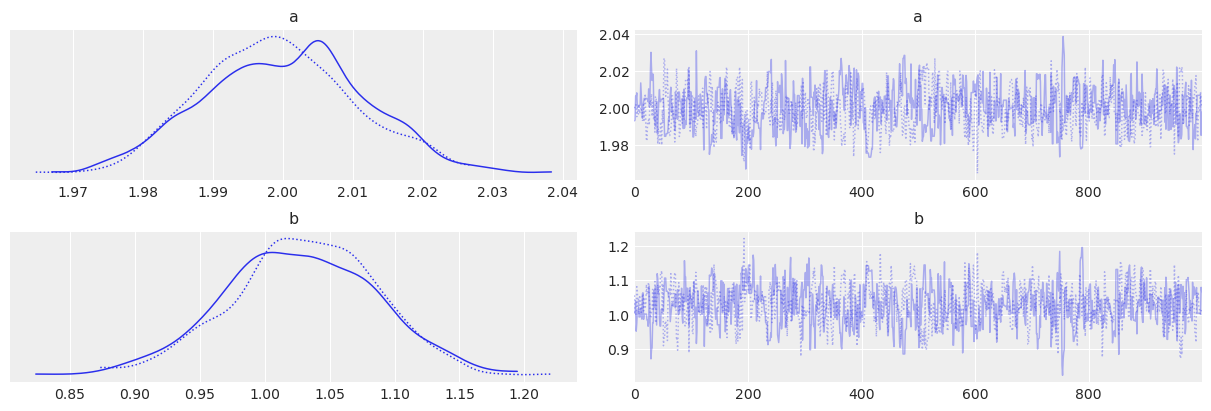

In [44]:
plt.figure()
ax = az.plot_trace(nuts_az_trace)
plt.show()

In [52]:
def z_integrand(a, b):
    p_a = np.exp(-(a - 2)**2 / 2) / np.sqrt(2 * np.pi)
    p_b = np.exp(-(b - 1)**2 / 2) / np.sqrt(2 * np.pi)
    l = np.prod(np.exp(-(y - a * x - b)**2 / (2 * 0.1**2)) / np.sqrt(2 * np.pi * 0.1**2))
    return l * p_a * p_b

from scipy import integrate
result = integrate.dblquad(z_integrand, 0.8, 1.2, 1.96, 2.04)
print(result)

(354.47752481652395, 1.4508249154328995e-05)


Hierarchical Radon Model ....

In [36]:
data = pd.read_csv(pm.get_data("radon.csv"))
data["log_radon"] = data["log_radon"].astype(theano.config.floatX)
county_names = data.county.unique()
county_idx = data.county_code.values

n_counties = len(data.county.unique())

In [37]:
with pm.Model() as hierarchical_model:
    # Hyperpriors for group nodes
    mu_a = pm.Normal("mu_a", mu=0.0, sigma=100)
    sigma_a = pm.HalfNormal("sigma_a", 5.0)
    mu_b = pm.Normal("mu_b", mu=0.0, sigma=100)
    sigma_b = pm.HalfNormal("sigma_b", 5.0)

    # Intercept for each county, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_counties).
    a = pm.Normal("a", mu=mu_a, sigma=sigma_a, shape=n_counties)
    # Intercept for each county, distributed around group mean mu_a
    b = pm.Normal("b", mu=mu_b, sigma=sigma_b, shape=n_counties)

    # Model error
    eps = pm.HalfCauchy("eps", 5.0)

    radon_est = a[county_idx] + b[county_idx] * data.floor.values

    # Data likelihood
    radon_like = pm.Normal("radon_like", mu=radon_est, sigma=eps, observed=data.log_radon)

First, let's sample the posterior using NUTS.

In [39]:
with hierarchical_model:
    hierarchical_trace = pm.sample(2000, tune=2000, target_accept=0.9)
    hierarchical_az_trace = az.from_pymc3(hierarchical_trace)

/home/richard/pymc3_dev/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 115 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


<Figure size 720x480 with 0 Axes>

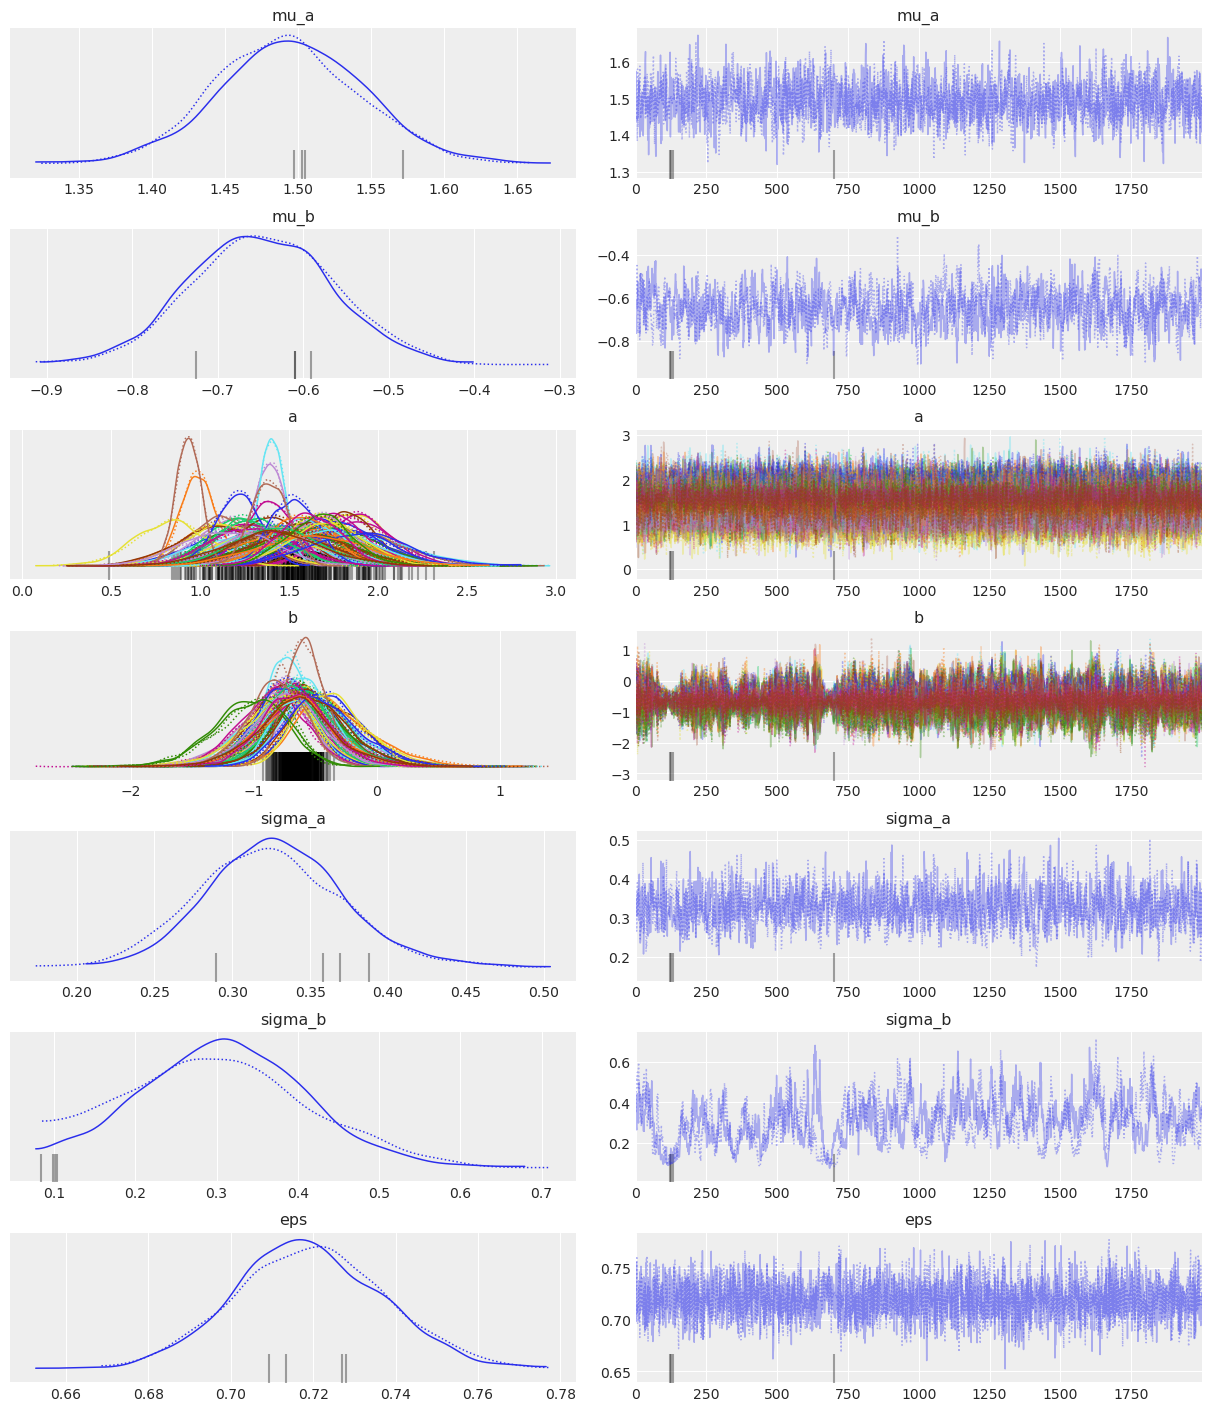

In [43]:
plt.figure()
ax = az.plot_trace(hierarchical_az_trace)
plt.show()

Now let's look at using NFMC.

In [44]:
with hierarchical_model:
    hierarchical_nf_trace = pm.sample_nfmc(500, optim_iter=1000, nf_iter=20, chains=1,
                                           frac_validate=0.2, alpha=(0.5,0.5), parallel=False)
    hierarchical_az_nf_trace = az.from_pymc3(hierarchical_nf_trace)

Initializing normalizing flow based sampling...
Sampling 1 chain Cores available for optimization: 0


Running initial optimization ...
Fitting the first NF approx to the prior optimized samples ...


KeyboardInterrupt: 